In [8]:
import sys
from skimage.io import imread, imshow
from PIL import Image
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [9]:
if 'C:/Program Files/ASAP 1.9/bin/' not in sys.path:
    sys.path.append('C:/Program Files/ASAP 1.9/bin/')
import multiresolutionimageinterface as mir

In [10]:
originalP='../Data/Originals/1.tif'
maskP='../Data/Masks/1_M.tif'

In [11]:
reader=mir.MultiResolutionImageReader()

In [12]:
mr_image=reader.open(originalP)

In [13]:
import openslide

In [14]:
s1=openslide.OpenSlide(originalP)
s2=openslide.OpenSlide(maskP)

In [15]:
o=s1.read_region(location=(38504-1024,22350-1024), level=0, size=(1024,1024))

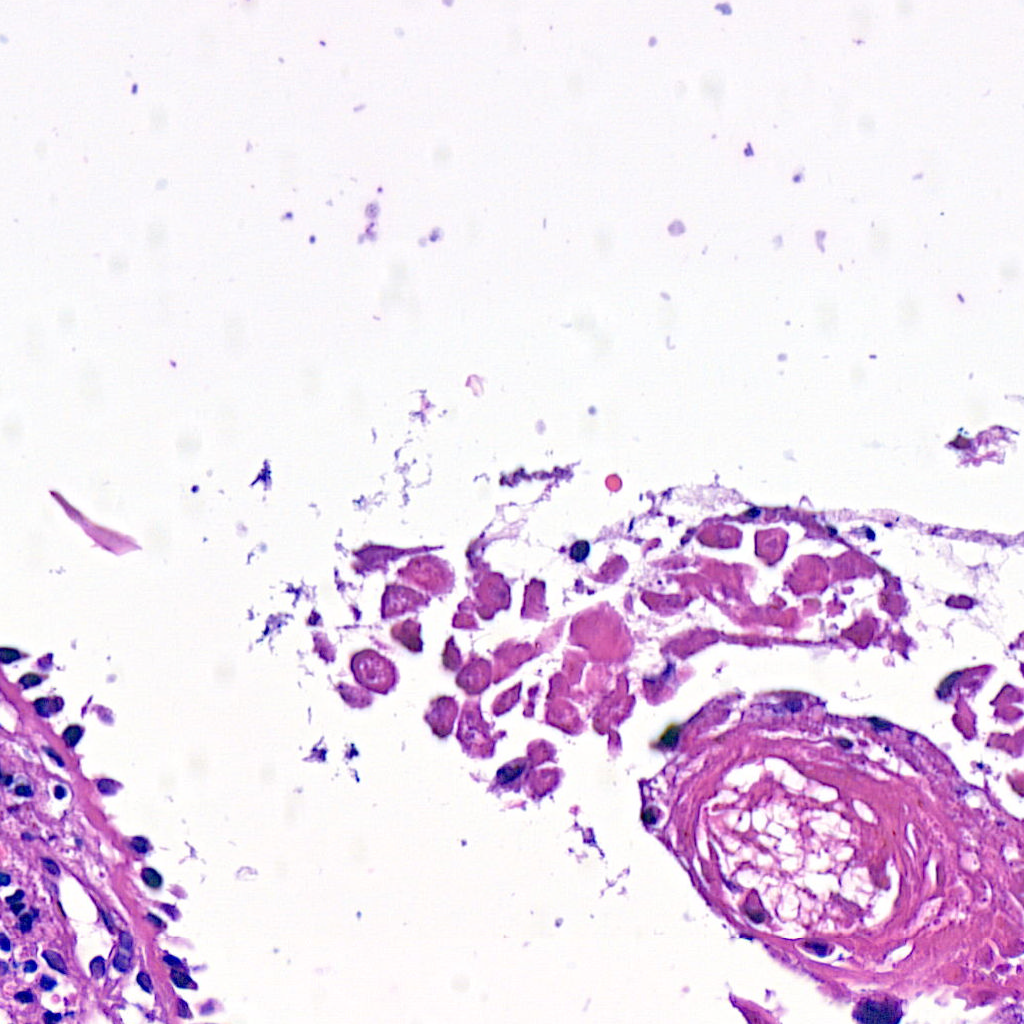

In [16]:
o

In [17]:
import random
r1=random.randint(0,1001)
r2=random.randint(0,1001)
m=s2.read_region(location=(38504-1024,22350-1024), level=0, size=(1024,1024))

In [18]:
type(m)

PIL.Image.Image

In [19]:
s=np.argwhere(m[:,:,0]==1)

TypeError: 'Image' object is not subscriptable

In [20]:
imshow(m[:,:,0])

TypeError: 'Image' object is not subscriptable

In [21]:
import random
r1=random.randint(0,101)
r2=random.randint(0,101)

In [22]:
import xml.etree.ElementTree


In [23]:
e = xml.etree.ElementTree.parse('../Data/Annotation/1.xml').getroot()

In [24]:
for atype in e.findall('Annotation'):
    print(atype.get('Name'))

In [25]:
import requests

In [26]:
import io
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET

In [27]:
f=io.open('../Data/Annotation/1.xml', mode='r', encoding='utf-8')

In [28]:
f=f.read()

In [29]:
tree = ET.parse('../Data/Annotation/1.xml')
root=tree.getroot()

In [30]:
for child in root:
    print(child.tag, child.attrib)

Annotations {}
AnnotationGroups {}


In [34]:
c=[elem.attrib for elem in root.iter() if 'X' in elem.attrib]
c=np.random.choice(c,1)

In [35]:
x=int(c[0]['X'])
y=int(c[0]['Y'])

In [36]:
x,y=[],[]
for cc in c:
    x.append(int(float(cc['X'])))
    y.append(int(float(cc['Y'])))

In [37]:
xmax=np.array(x).max()
xmin=np.array(x).min()
ymax=np.array(y).max()
ymin=np.array(y).min()
s1=np.arange(xmin, xmax, 1)
s2=np.arange(ymin, ymax, 1)

In [38]:
r1=np.random.choice(s1,1)
r2=np.random.choice(s2,1)

ValueError: a must be non-empty

In [39]:
originalP='../Data/Originals/'
masksP='../Data/Masks/'
annotationP='../Data/Annotation/'

def getTrainData(originalP, masksP, annotationP, k):
    s=[]
    listnames=[name.split('.')[0] for name in os.listdir(originalP)]
    for name in listnames:
        d={'imagesP':originalP+name+'.tif',
           'masksP':masksP+name+'_M.tif',
           'xmlP':annotationP+name+'.xml'}
        s.append(d)
    return(list(np.random.choice(s, k)))

In [40]:
t=getTrainData(originalP, masksP, annotationP, 1000)
v=getTrainData(originalP, masksP, annotationP, 100)

In [41]:
from torch.utils.data import Dataset
from torchvision import transforms as T
import xml.etree.ElementTree as ET
import sys

from PIL import ImageFilter

In [42]:
from torch.utils.data import DataLoader
import torch

from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Accuracy
from ignite.contrib.handlers import ProgressBar



In [65]:
from torch.utils.data import Dataset
from torchvision import transforms as T
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image
import sys


class CancerDataset(Dataset):
    def __init__(self, trainData, patch_size, image_aug=None, mask_aug=None):
        self.trainData = trainData
        self.patch_size = patch_size
        self.image_aug = image_aug
        self.mask_aug = mask_aug

    def __len__(self):
        return(len(self.trainData))

    def __getitem__(self, index):
        X, Y = self.getXY(index)
        image, mask = self.getImages(X, Y, index)
        return(image, mask)
#         if self.image_aug is not None:
#             image = self.image_aug(image)
#         else:
#             image = T.ToTensor()(image)
#         if self.mask_aug is not None:
#             mask = self.mask_aug(mask)
#         else:
#             mask = T.ToTensor()(mask)

#         return(image.float(), mask.float())

    def getImages(self, X, Y, index):
        if 'C:/Program Files/ASAP 1.9/bin/' not in sys.path:
            sys.path.append('C:/Program Files/ASAP 1.9/bin/')
        import multiresolutionimageinterface as mir
        reader = mir.MultiResolutionImageReader()
        image = reader.open(self.trainData[index]['imagesP'])
        import openslide
        slide = openslide.OpenSlide(self.trainData[index]['imagesP'])
        mask = openslide.OpenSlide(self.trainData[index]['masksP'])
        slide_r = slide.read_region(location=(X, Y), level=1, size=self.patch_size)
        slide_r=slide_r.convert('RGB')
        mask_r = mask.read_region(location=(X, Y), level=1, size=self.patch_size)
        mask_r = np.array(mask_r)
        mask_r = mask_r[:, :, 0]
        mask_r = Image.fromarray(np.uint8(mask_r)*255)
        mask_r=mask_r.convert('RGB')

        return(slide_r, mask_r)

    def getXY(self, index):
        path = self.trainData[index]['xmlP']
        tree = ET.parse(path)
        root = tree.getroot()
        coord = [elem.attrib for elem in root.iter() if 'X' in elem.attrib]
        coord = np.random.choice(coord, 1)
        X = int(float(coord[0]['X']))
        Y = int(float(coord[0]['Y']))

        
        return(X, Y)


In [52]:
trainDataset=CancerDataset(t, (1024,1024))
validDataset=CancerDataset(t, (1024,1024))

In [45]:
trainLoader=DataLoader(trainDataset, batch_size=4, pin_memory=True, shuffle=True)
validLoader=DataLoader(validDataset, batch_size=4, pin_memory=True, shuffle=False)

In [46]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [66]:
im1=trainDataset[0][0]
im2=trainDataset[0][1]

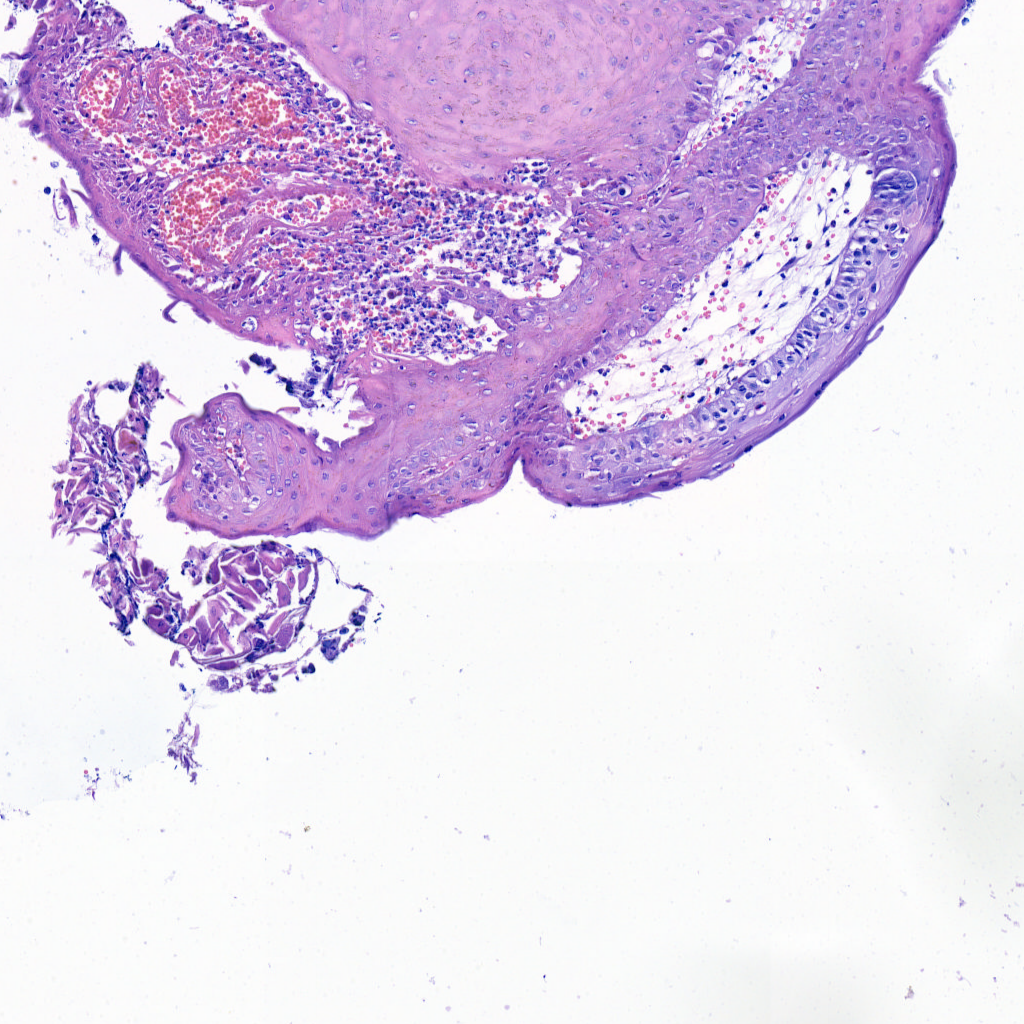

In [67]:
im1

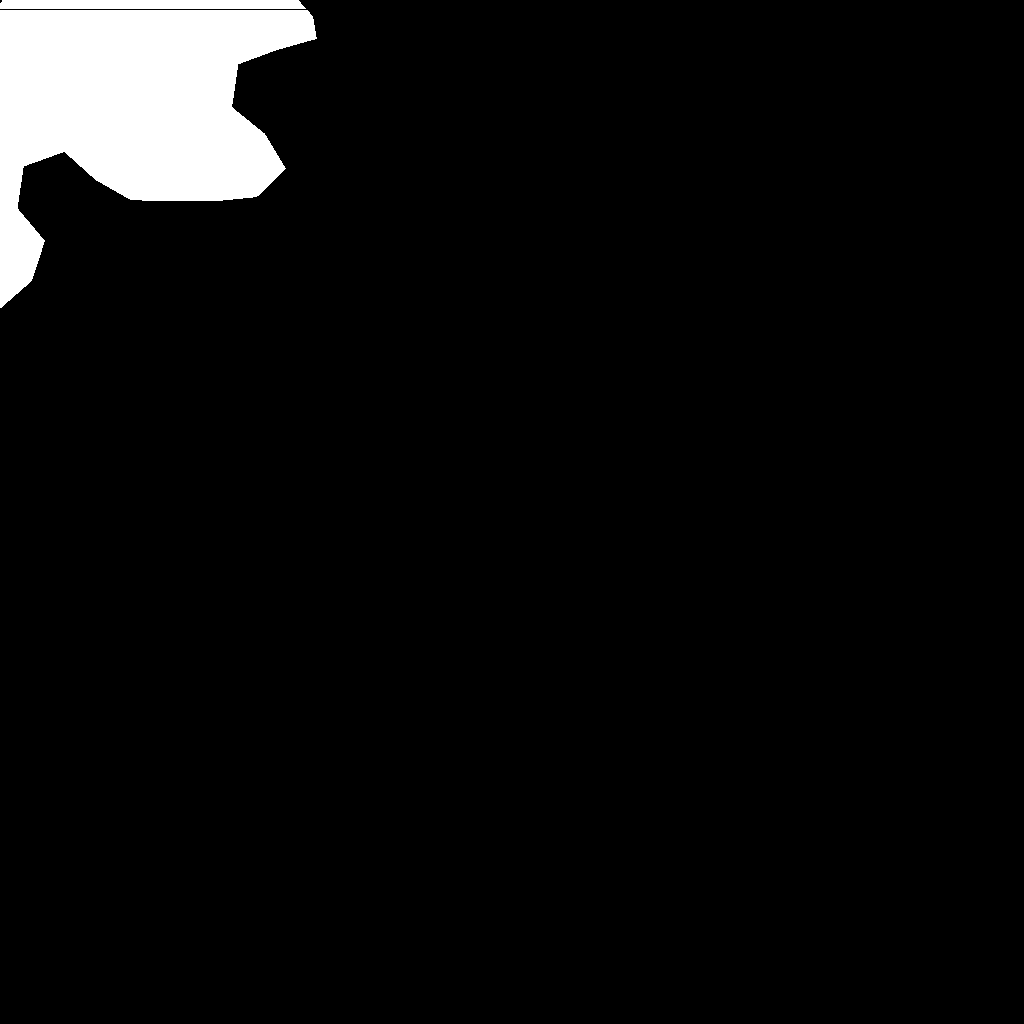

In [68]:
im2